C:\Users\HP\miniconda3\envs\tf210\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\HP\miniconda3\envs\tf210\lib\site-packages\xgboost\training.py:183: UserWarning: [12:01:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:

              precision    recall  f1-score   support

      benign     0.9856    0.9939    0.9897     64216
  defacement     0.9923    0.9967    0.9945     14468
     malware     0.9966    0.9561    0.9759      4878
    phishing     0.9551    0.9276    0.9412     14117

    accuracy                         0.9828     97679
   macro avg     0.9824    0.9686    0.9753     97679
weighted avg     0.9827    0.9828    0.9827     97679



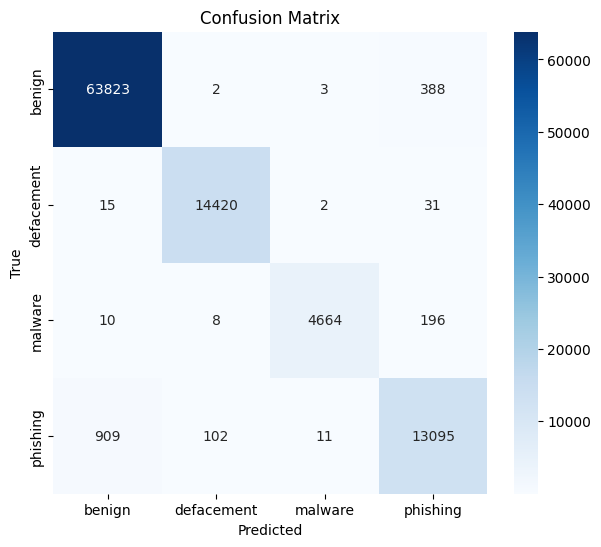


Model saved as malicious_url_detector.h5


In [7]:
# requirements: pandas scikit-learn xgboost matplotlib seaborn h5py
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import joblib
import tldextract
import h5py

# -----------------------
# 1) Load dataset
# -----------------------
df = pd.read_csv("malicious_urls.csv")[['url', 'type']].dropna()
df['type'] = df['type'].astype(str)

# -----------------------
# 2) Lexical feature extraction
# -----------------------
def lexical_features(urls):
    out = []
    for u in urls:
        u = str(u)
        parsed = tldextract.extract(u)
        subdomain = parsed.subdomain
        domain = parsed.domain
        suffix = parsed.suffix
        features = {
            'len': len(u),
            'count_slash': u.count('/'),
            'count_dot': u.count('.'),
            'count_dash': u.count('-'),
            'count_at': u.count('@'),
            'count_qm': u.count('?'),
            'count_eq': u.count('='),
            'count_digits': sum(ch.isdigit() for ch in u),
            'num_subdomain_parts': 0 if not subdomain else len(subdomain.split('.')),
            'has_ip': 1 if re.match(r'^(http[s]?://)?\d+\.\d+\.\d+\.\d+', u) else 0,
            'tld_len': len(suffix),
            'domain_len': len(domain),
            'entropy': -sum((u.count(c)/len(u)) * np.log2(u.count(c)/len(u) + 1e-9) for c in set(u))
        }
        out.append(list(features.values()))
    return np.array(out)

# -----------------------
# 3) TF-IDF feature extraction
# -----------------------
def url_tokenizer(s):
    return re.split(r'[:/?=&._\-\.]+', s)

tfidf = TfidfVectorizer(tokenizer=url_tokenizer, ngram_range=(1,2), max_features=20000)

# -----------------------
# 4) Encode labels + split
# -----------------------
X_urls = df['url'].values
y = df['type'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train_urls, X_test_urls, y_train, y_test = train_test_split(
    X_urls, y_encoded, test_size=0.15, stratify=y_encoded, random_state=42
)

X_train_lex = lexical_features(X_train_urls)
X_test_lex = lexical_features(X_test_urls)

X_train_tfidf = tfidf.fit_transform(X_train_urls)
X_test_tfidf = tfidf.transform(X_test_urls)

from scipy.sparse import hstack
X_train = hstack([X_train_tfidf, X_train_lex])
X_test = hstack([X_test_tfidf, X_test_lex])

# -----------------------
# 5) Train XGBoost model
# -----------------------
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=200,
    max_depth=7,
    n_jobs=8
)
model.fit(X_train, y_train)

# -----------------------
# 6) Evaluate
# -----------------------
y_pred = model.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# -----------------------
# 7) Save model as .h5
# -----------------------
# Save model + tfidf + label encoder so you can reload later
joblib.dump((model, tfidf, le), "malicious_url_detector.h5")
print("\nModel saved as malicious_url_detector.h5")


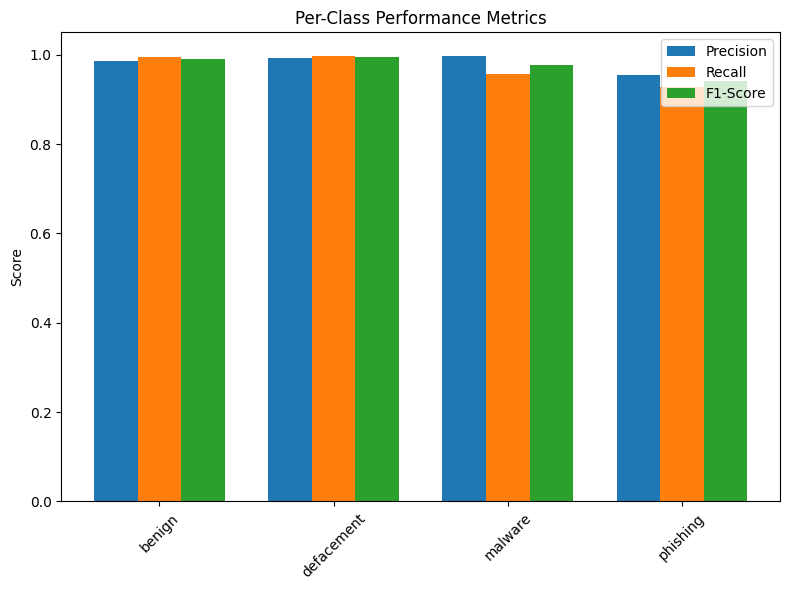

In [10]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate per-class metrics
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred)

# Plot bar chart
plt.figure(figsize=(8,6))
x = np.arange(len(le.classes_))
width = 0.25

plt.bar(x - width, prec, width, label="Precision")
plt.bar(x, rec, width, label="Recall")
plt.bar(x + width, f1, width, label="F1-Score")

plt.xticks(x, le.classes_, rotation=45)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.title("Per-Class Performance Metrics")
plt.legend()
plt.tight_layout()
plt.show()
